In [1]:
import jupyterthemes as jt
from jupyterthemes import jtplot
!jt -l
!jt -t onedork -ofs 10 -dfs 9 -nfs 9 -tfs 11
jtplot.style(theme = 'onedork', fscale = 1.4, context = 'notebook', ticks = True, grid = False)

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [2]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.pipeline import Pipeline
from matplotlib import pylab as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import string
import seaborn as sns
import re
from string import punctuation
from pymorphy2 import MorphAnalyzer
from num2words import num2words
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# EDA

In [3]:
data = pd.read_csv('train.csv', nrows = 200000)
data.shape

(200000, 9)

In [4]:
data.head(5)

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad
0,Диван-кровать,Продаем диван-кровать. Удобный механизм - евро...,Мебель и интерьер,Для дома и дачи,7000.0,Россия,Москва,2019-06-01 00:00:15.180656,0
1,Кожух рулевой колонки Даф хф 91 4509834,Кожух рулевой колонки DAF XF 94 (60066004)/\n ...,Запчасти и аксессуары,Транспорт,2290.0,Россия,Москва,2019-06-01 00:00:44.317933,0
2,Дешёвый буст аккаунтов Dota 4,! Буст аккаунтов с ммр выше 1000ммр не беру ! ...,Предложение услуг,Услуги,200.0,Северная Осетия,Владикавказ,2019-06-01 00:00:50.249692,1
3,Телевизор sharp.Смарт тв.Интернет,Продам телевизор . Диагональ 450.наличие входа...,Аудио и видео,Бытовая электроника,25000.0,Калининградская область,Советск,2019-06-01 00:00:50.325799,1
4,Открытка-конверт,Открытки-конверты ручной работы/\nВыполнены в ...,Коллекционирование,Хобби и отдых,150.0,Ставропольский край,Ессентукская,2019-06-01 00:00:56.632655,0


Объявлений с указанной контактной информацией примерно в 2.5 раза меньше

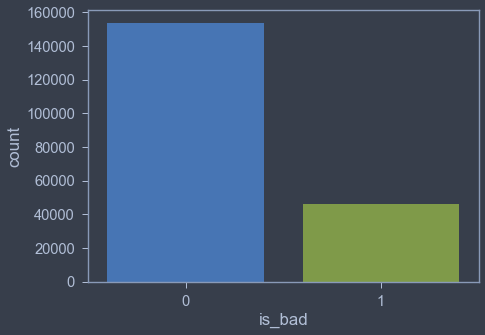

In [5]:
plt.figure(figsize = (7, 5))
sns.countplot(data['is_bad'])
plt.show()

Разделим объявления по наличию контактной информации

- 1 - имеется контактная информация
- 0 - отсутствует контактная информация

In [6]:
data_1 = data[data['is_bad'] == 1]
data_0 = data[data['is_bad'] == 0]

$ Length $ $ Advertisements $

Количество слов в описании для двух групп объявлений

In [7]:
length_1 = data_1['description'].apply(lambda x: len(x))
length_0 = data_0['description'].apply(lambda x: len(x))

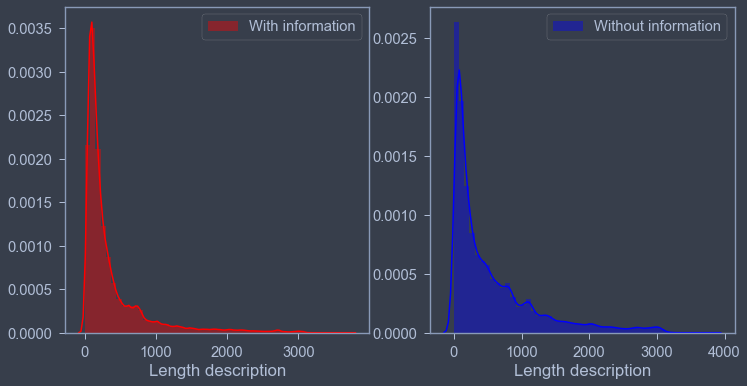

In [8]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
sns.distplot(length_1, color = 'red', label = 'With information')
plt.xlabel('Length description')
plt.legend()

plt.subplot(1, 2, 2)
sns.distplot(length_0, color = 'blue', label = 'Without information')
plt.xlabel('Length description')
plt.legend()

plt.show()

In [9]:
#length per word in description
mean_length_1 = data_1['description'].str.split().apply(lambda x: [len(i) for i in x])
mean_length_0 = data_0['description'].str.split().apply(lambda x: [len(i) for i in x])

#Mean length
mean_length_1 = mean_length_1.map(lambda x: np.mean(x))
mean_length_0 = mean_length_0.map(lambda x: np.mean(x))

Средняя длина слов в описаниях для двух типов объявлений находится на интервале от 0 до 15

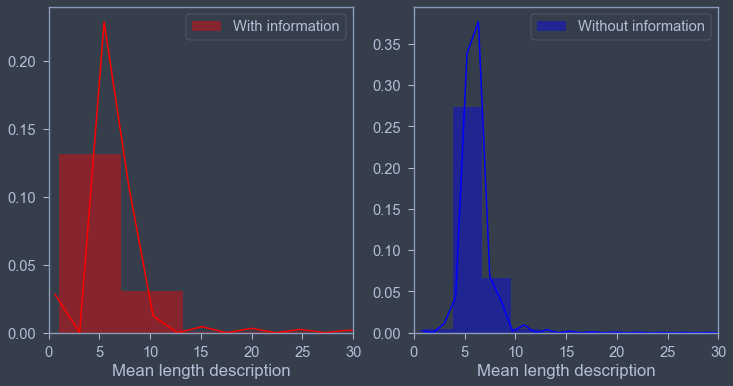

In [10]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
sns.distplot(mean_length_1, color = 'red', label = 'With information')
plt.xlabel('Mean length description')
plt.xlim(0, 30)
plt.legend()

plt.subplot(1, 2, 2)
sns.distplot(mean_length_0, color = 'blue', label = 'Without information')
plt.xlabel('Mean length description')
plt.xlim(0, 30)
plt.legend()

plt.show()

$ Category $

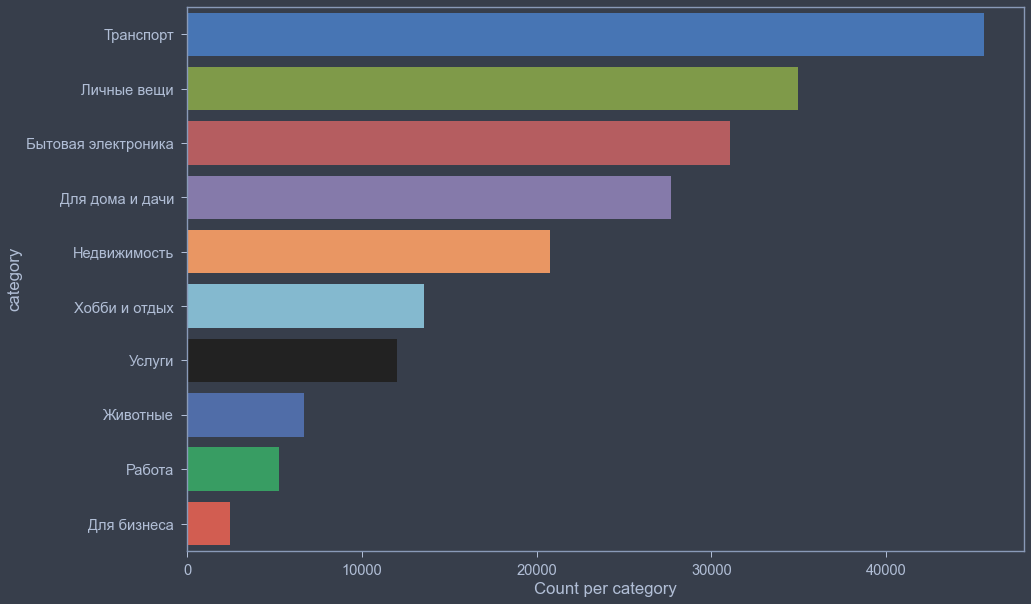

In [11]:
plt.figure(figsize = (15, 10))
sns.countplot(y = data['category'],
              order = data['category'].value_counts().index)
plt.xlabel('Count per category')
plt.show()

В категории $ Животные $ более половины объявлений с указанной контактной информацией
 
В категории $ Бытовая $ $ электроника $ самый низкий процент объявленийс указанной информацией

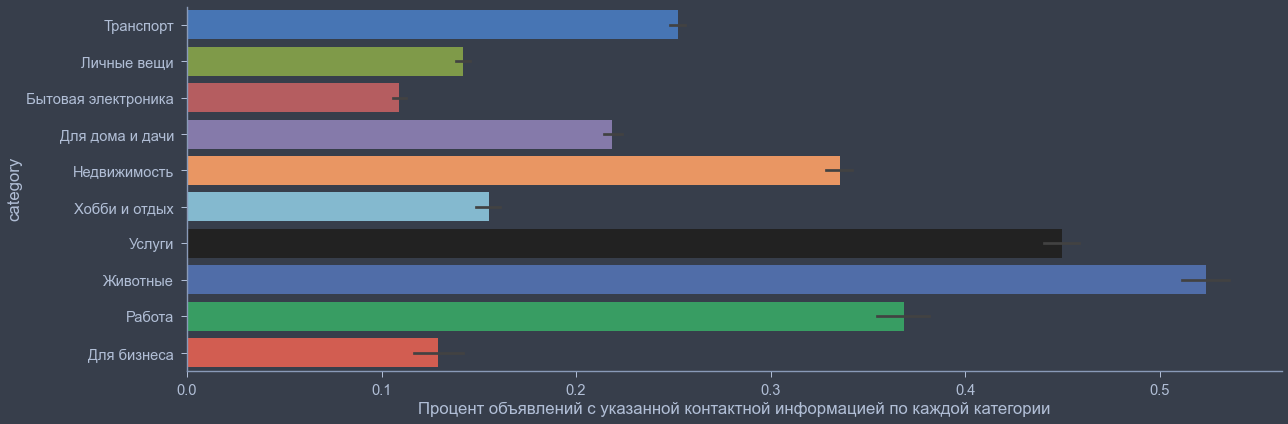

In [12]:
sns.catplot(x = 'is_bad', y = 'category', data = data,
            kind = 'bar', height = 6, aspect = 3,
            order = data['category'].value_counts().index)
plt.xlabel('Процент объявлений с указанной контактной информацией по каждой категории')
plt.show()

Запчасти и аксессуары сильно преобладают в выборке

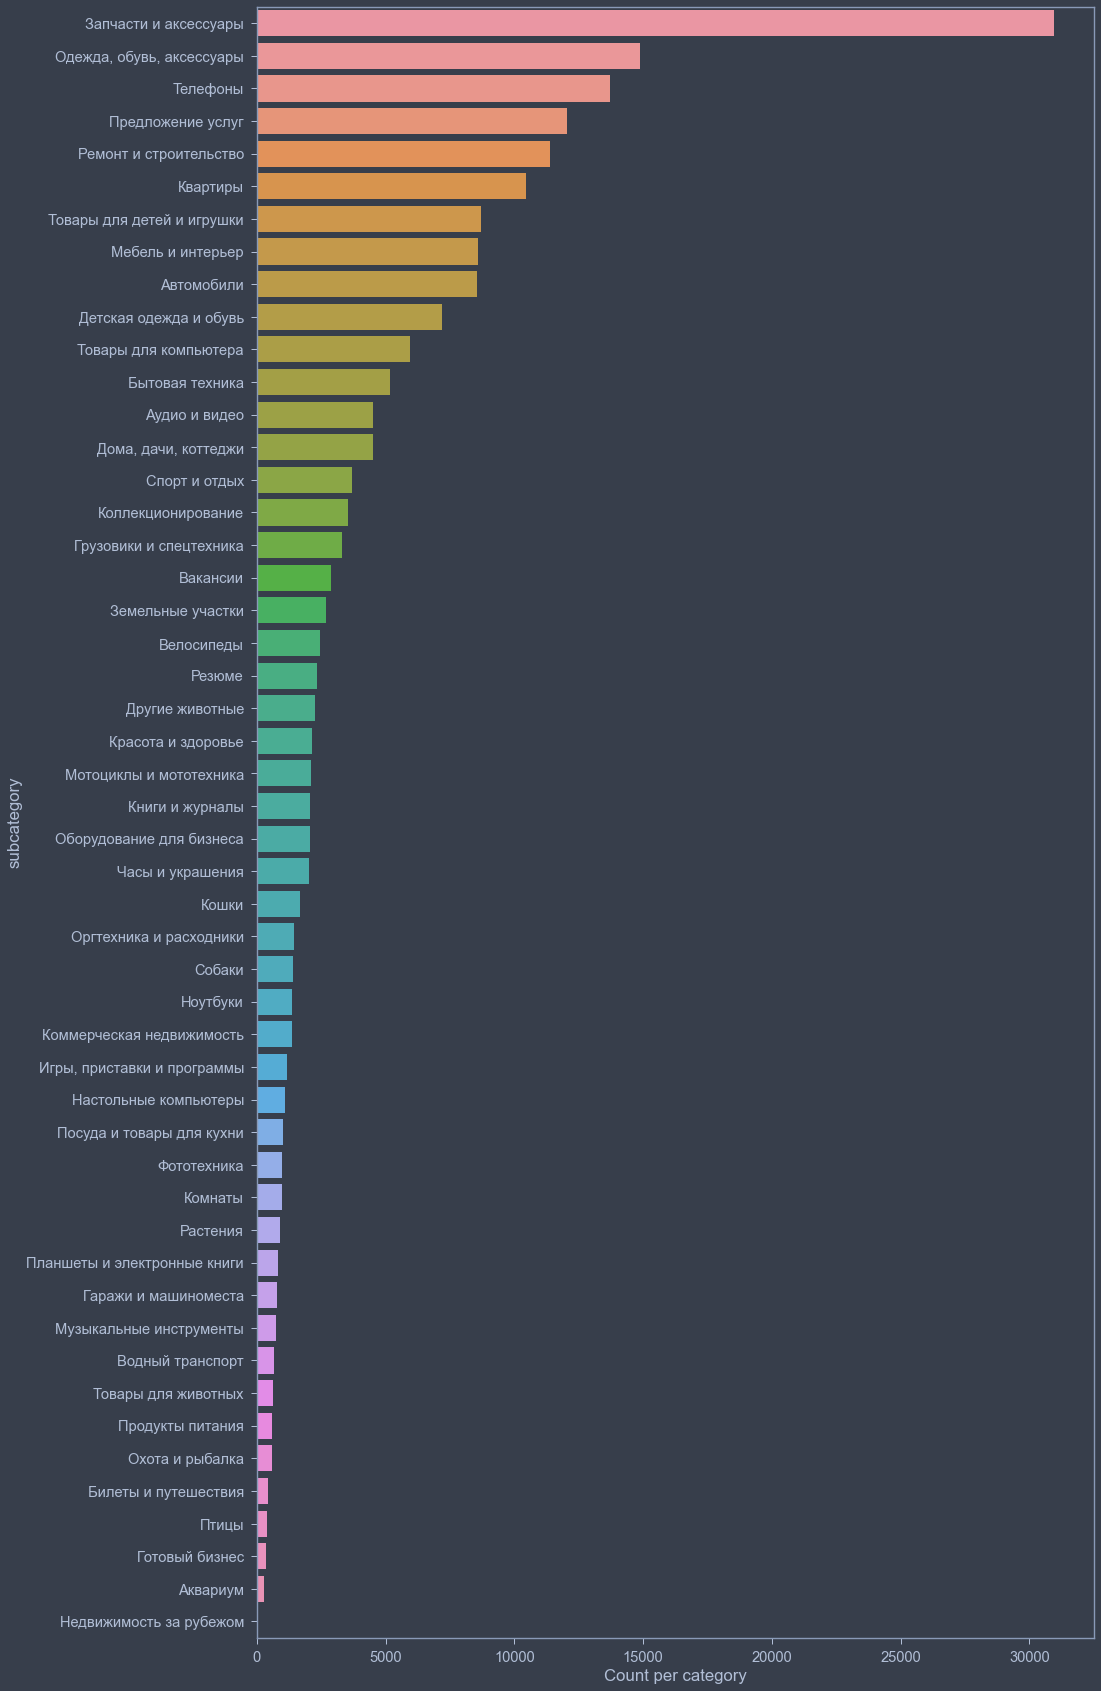

In [13]:
plt.figure(figsize = (15, 30))
sns.countplot(y = data['subcategory'],
              order = data['subcategory'].value_counts().index)
plt.xlabel('Count per category')
plt.show()

В преобладающей подкатегории запчасти и аксессуары только 20 % объявлений с указанной информацией

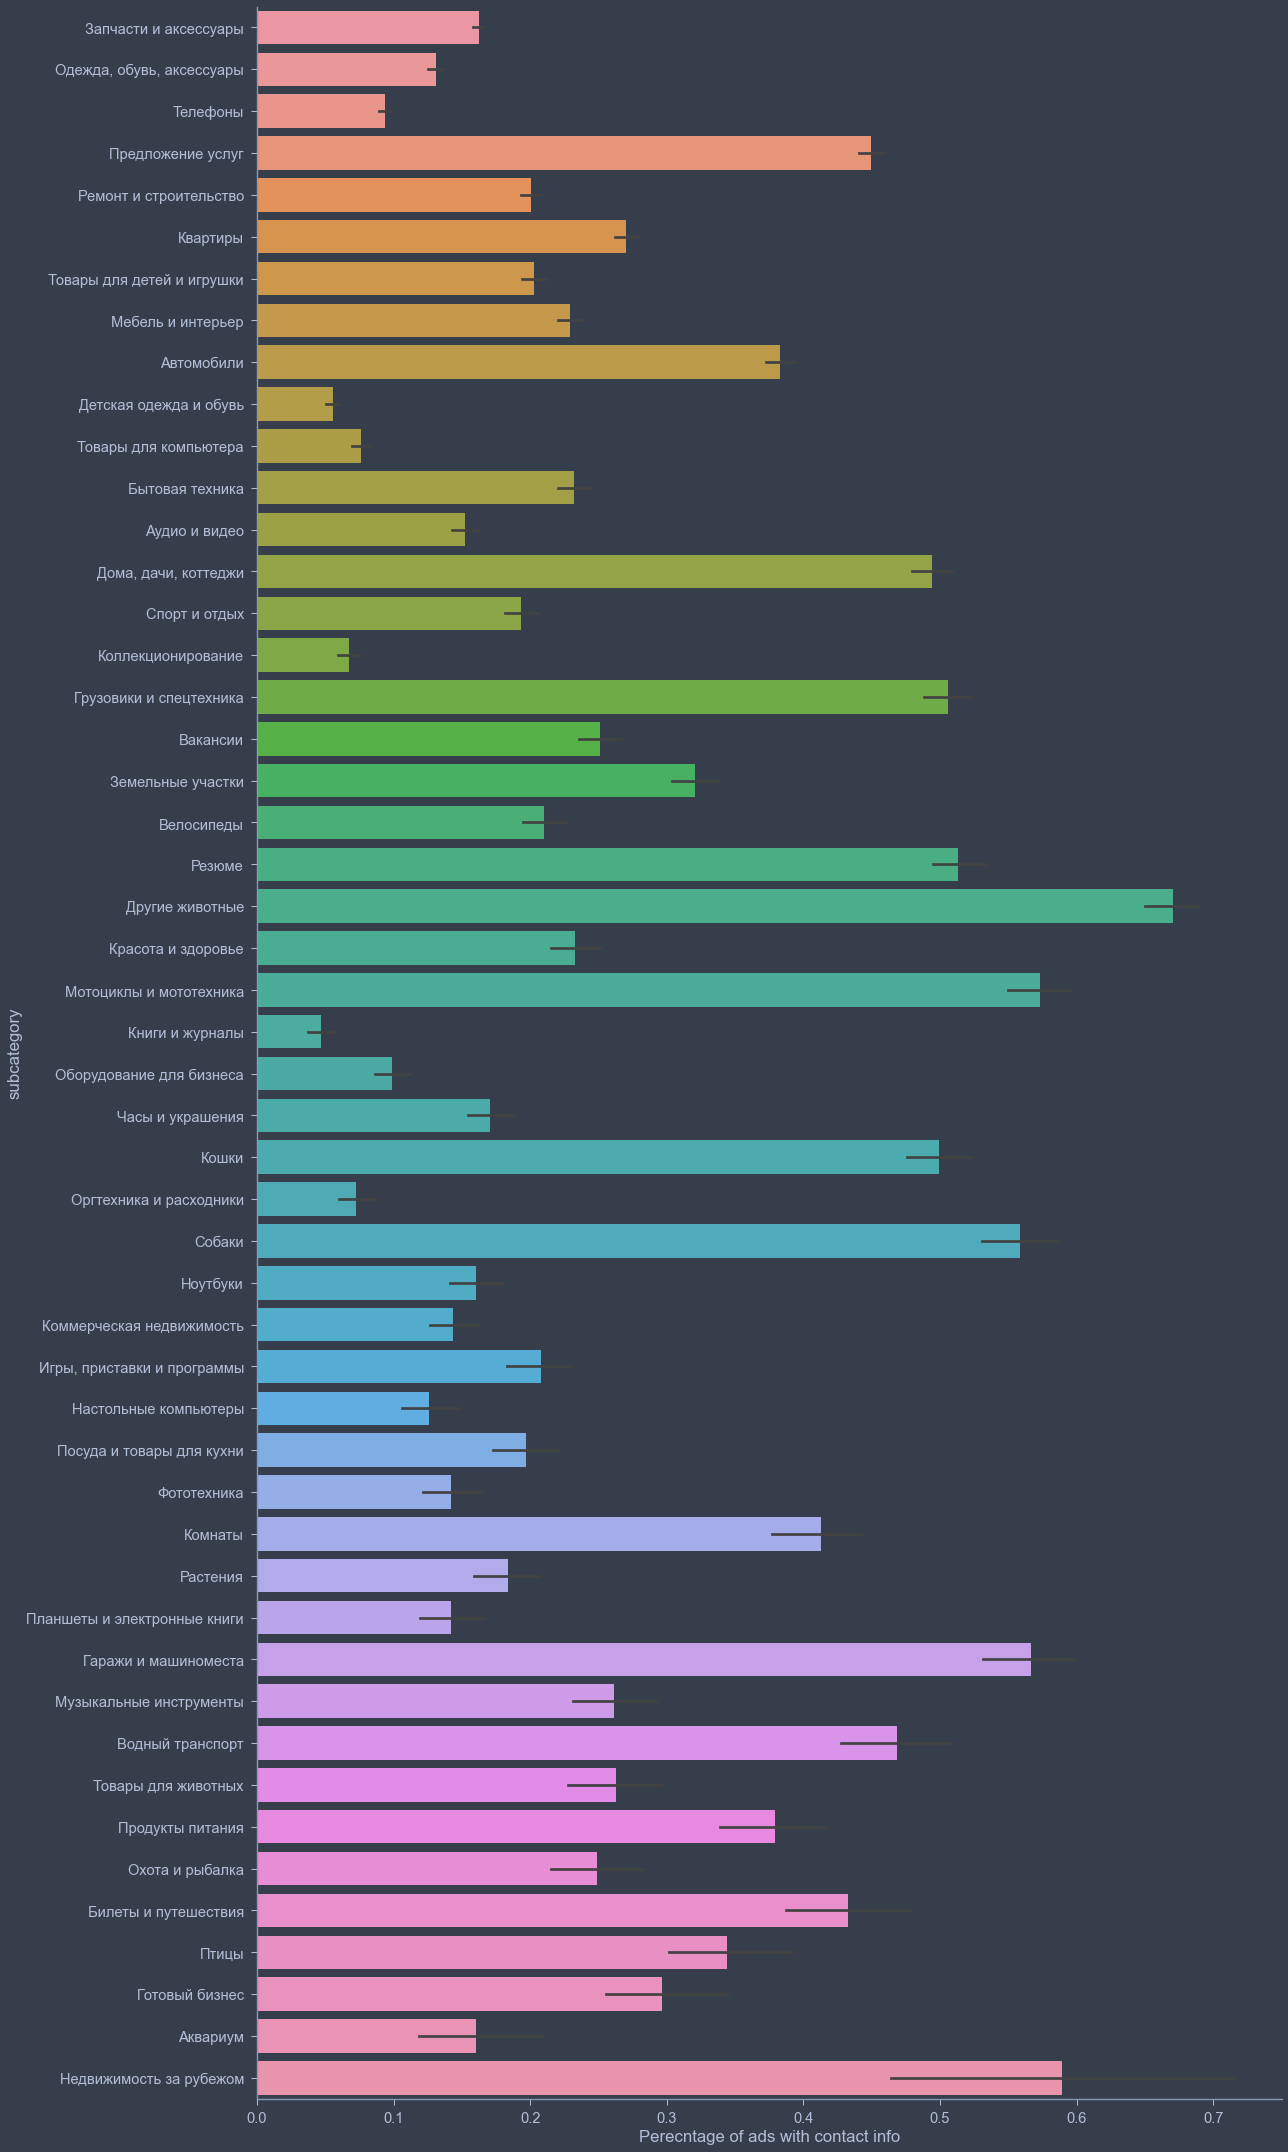

In [14]:
sns.catplot(x = 'is_bad', y = 'subcategory', data = data,
            kind = 'bar', height = 30, aspect = 0.6,
            order = data['subcategory'].value_counts().index)
plt.xlabel('Perecntage of ads with contact info')
plt.show()

$ Price $ $ distribution $

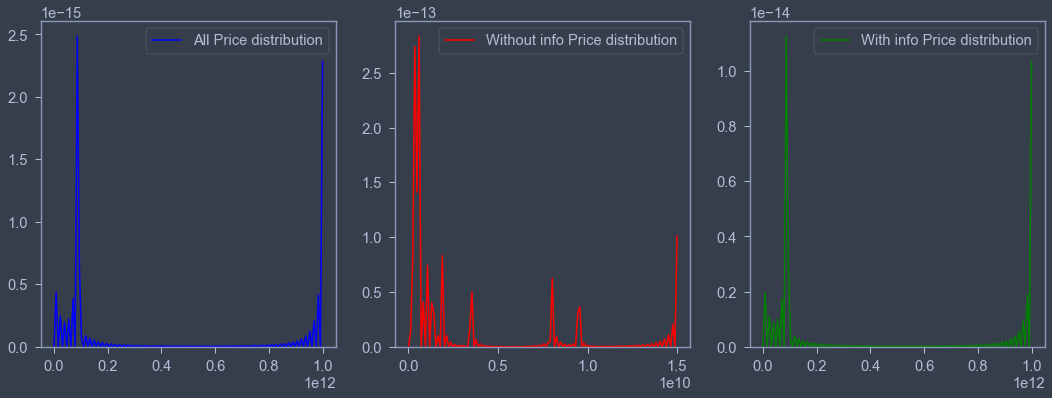

In [15]:
plt.figure(figsize = (18, 6))

plt.subplot(1, 3, 1)
sns.kdeplot(data['price'], color = 'blue', label = 'All Price distribution')
plt.legend()

plt.subplot(1, 3, 2)
sns.kdeplot(data_0['price'], color = 'red', label = 'Without info Price distribution')
plt.legend()

plt.subplot(1, 3, 3)
sns.kdeplot(data_1['price'], color = 'green', label = 'With info Price distribution')
plt.legend()

plt.show()

$ Count $ $ n-grams $

In [16]:
def count_grams(data, n_min, n_max):
    vectorizer_ngram = CountVectorizer(ngram_range = (n_min, n_max))
    X = vectorizer_ngram.fit_transform(data)
    ngrams = np.ravel(X.sum(axis = 0))
    count_ngrams = []
    for count, ngram in zip(ngrams, vectorizer_ngram.get_feature_names()):
        count_ngrams.append((count, ngram))
    count_ngrams.sort()
    count_ngrams = pd.DataFrame(count_ngrams[-20:], columns = ['count', 'ngrams'])
    return count_ngrams.sort_values(by = 'count', ascending = False)

In [17]:
#Text lower
data['description'] = data['description'].apply(lambda x: x.lower())
data_1['description'] = data_1['description'].apply(lambda x: x.lower())
data_0['description'] = data_0['description'].apply(lambda x: x.lower())

#count n-grams
unograms = count_grams(data['description'], 1, 1)
bigrams = count_grams(data['description'], 2, 2)
trigrams = count_grams(data['description'], 3, 3)

<ipython-input-17-d14b0b4b40f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['description'] = data_1['description'].apply(lambda x: x.lower())
<ipython-input-17-d14b0b4b40f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_0['description'] = data_0['description'].apply(lambda x: x.lower())


Во всех н-граммах преобладают стоп-слова 

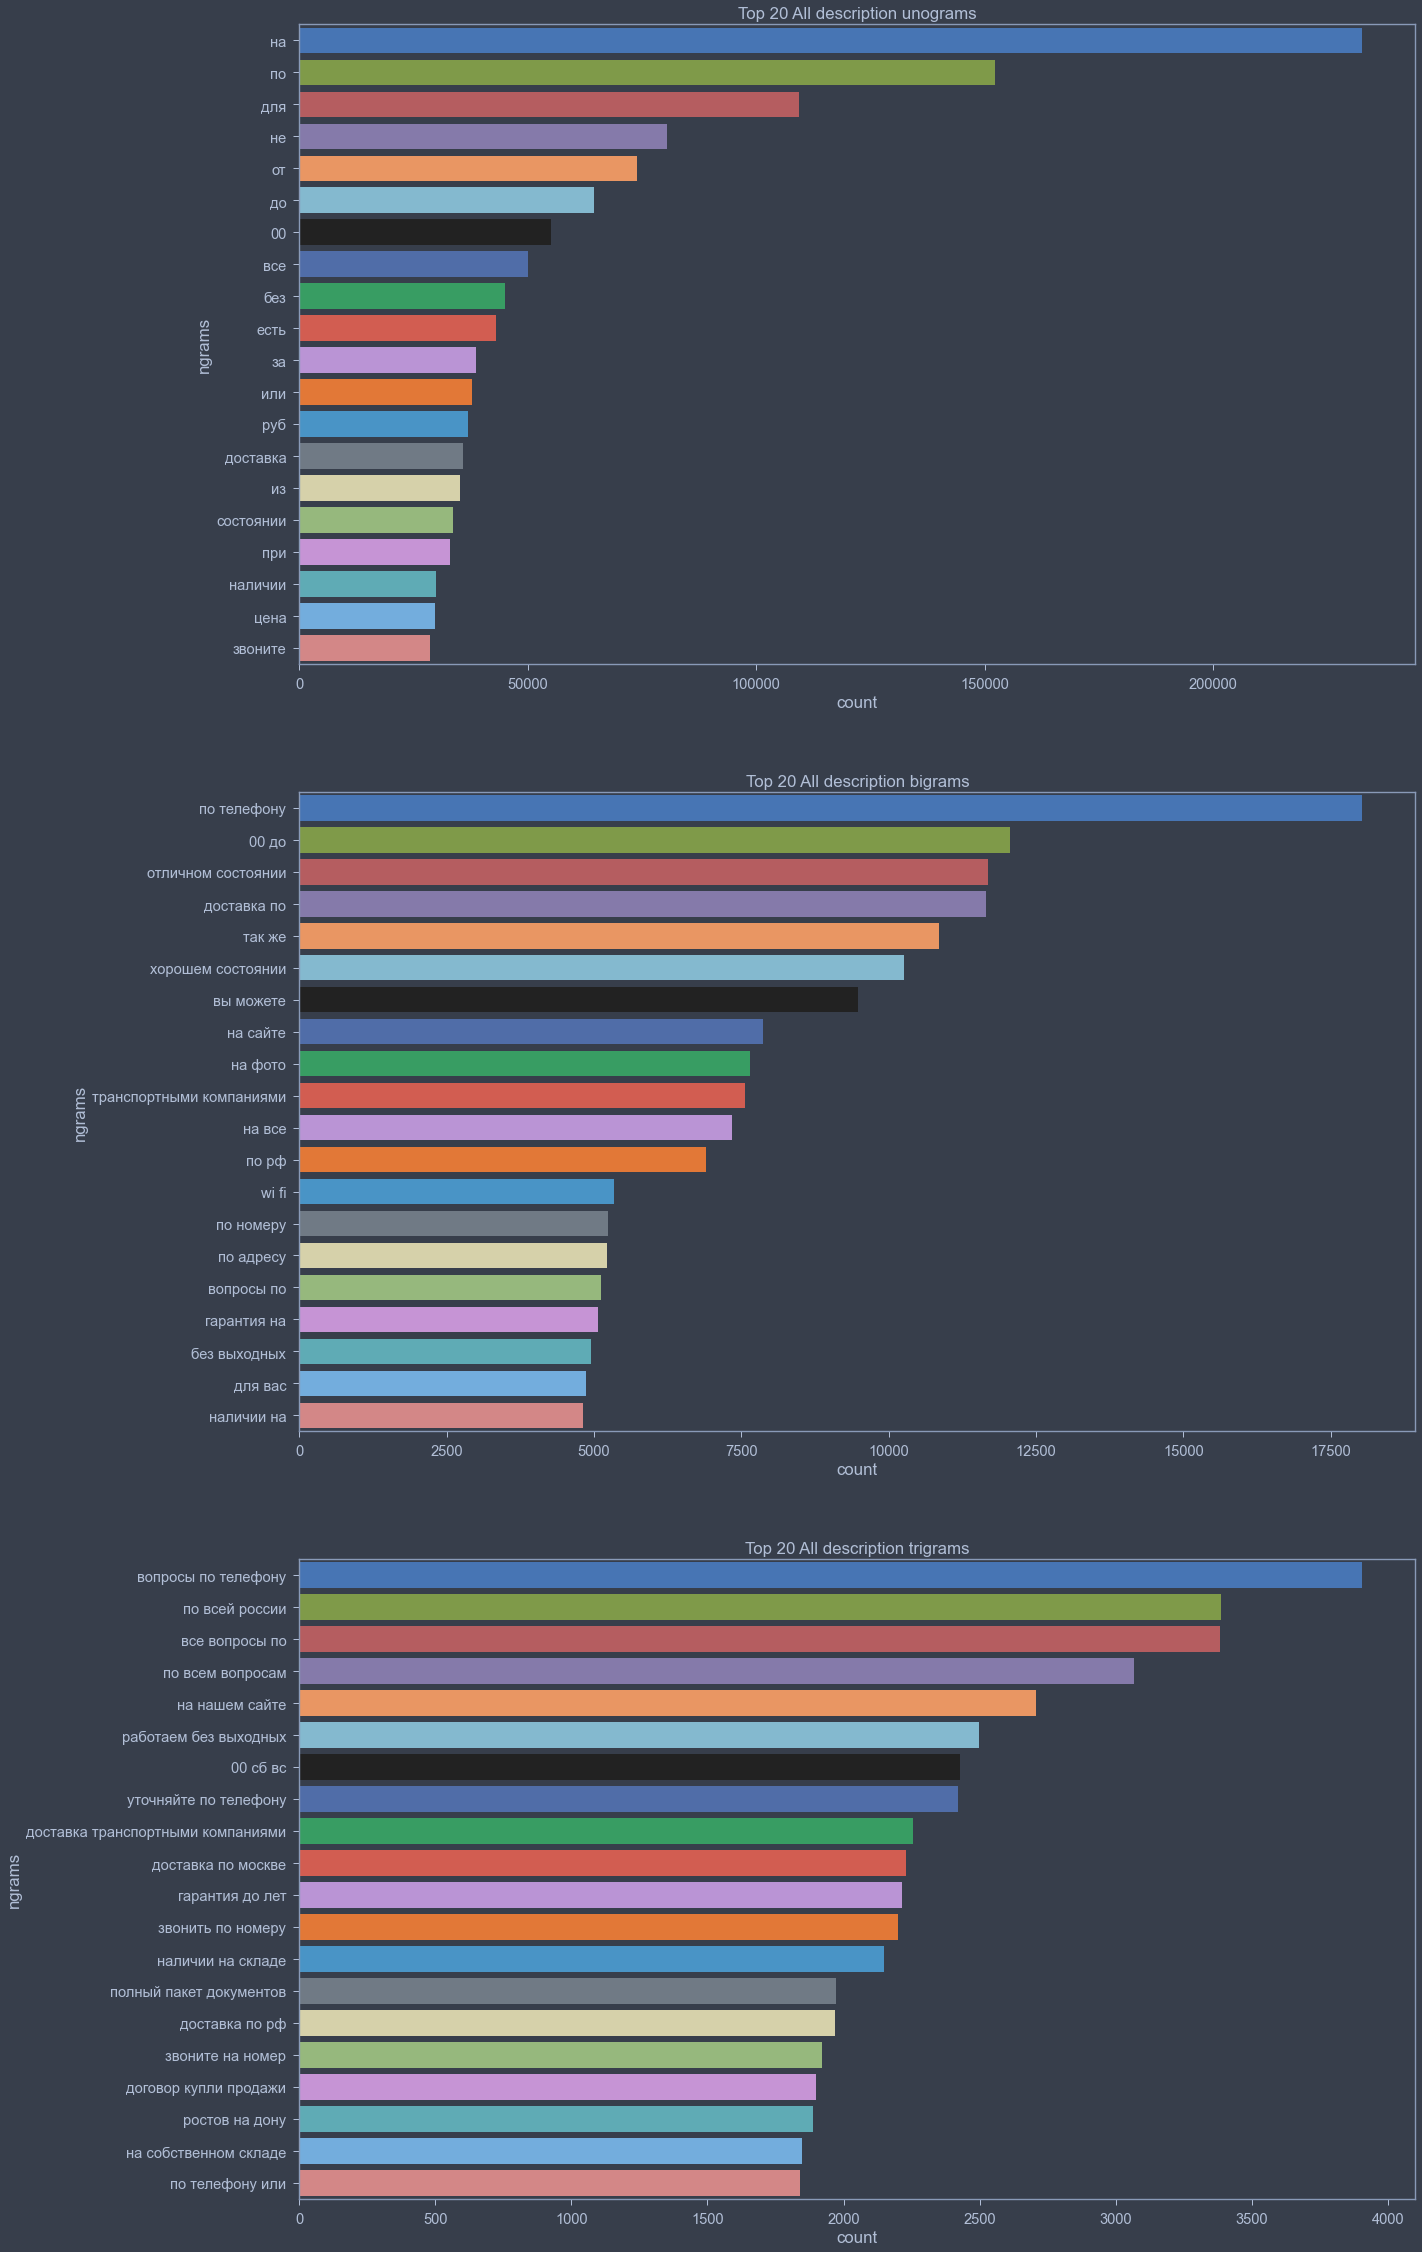

In [18]:
plt.figure(figsize = (20, 40))

plt.subplot(3, 1, 1)
sns.barplot(x = unograms['count'], y = unograms['ngrams'])
plt.title('Top 20 All description unograms')

plt.subplot(3, 1, 2)
sns.barplot(x = bigrams['count'], y = bigrams['ngrams'])
plt.title('Top 20 All description bigrams')

plt.subplot(3, 1, 3)
sns.barplot(x = trigrams['count'], y = trigrams['ngrams'])
plt.title('Top 20 All description trigrams')

plt.show()

$ N-grams $ $ for $ $ description $

In [19]:
#n-gram (without info)
unograms_0 = count_grams(data_0['description'], 1, 1)
bigrams_0 = count_grams(data_0['description'], 2, 2)
trigrams_0 = count_grams(data_0['description'], 3, 3)

#n-gram (with info)
unograms_1 = count_grams(data_1['description'], 1, 1)
bigrams_1 = count_grams(data_1['description'], 2, 2)
trigrams_1 = count_grams(data_1['description'], 3, 3)

Из-за большого количества стоп-слов разницы между двумя типами объявлений не наблюдается

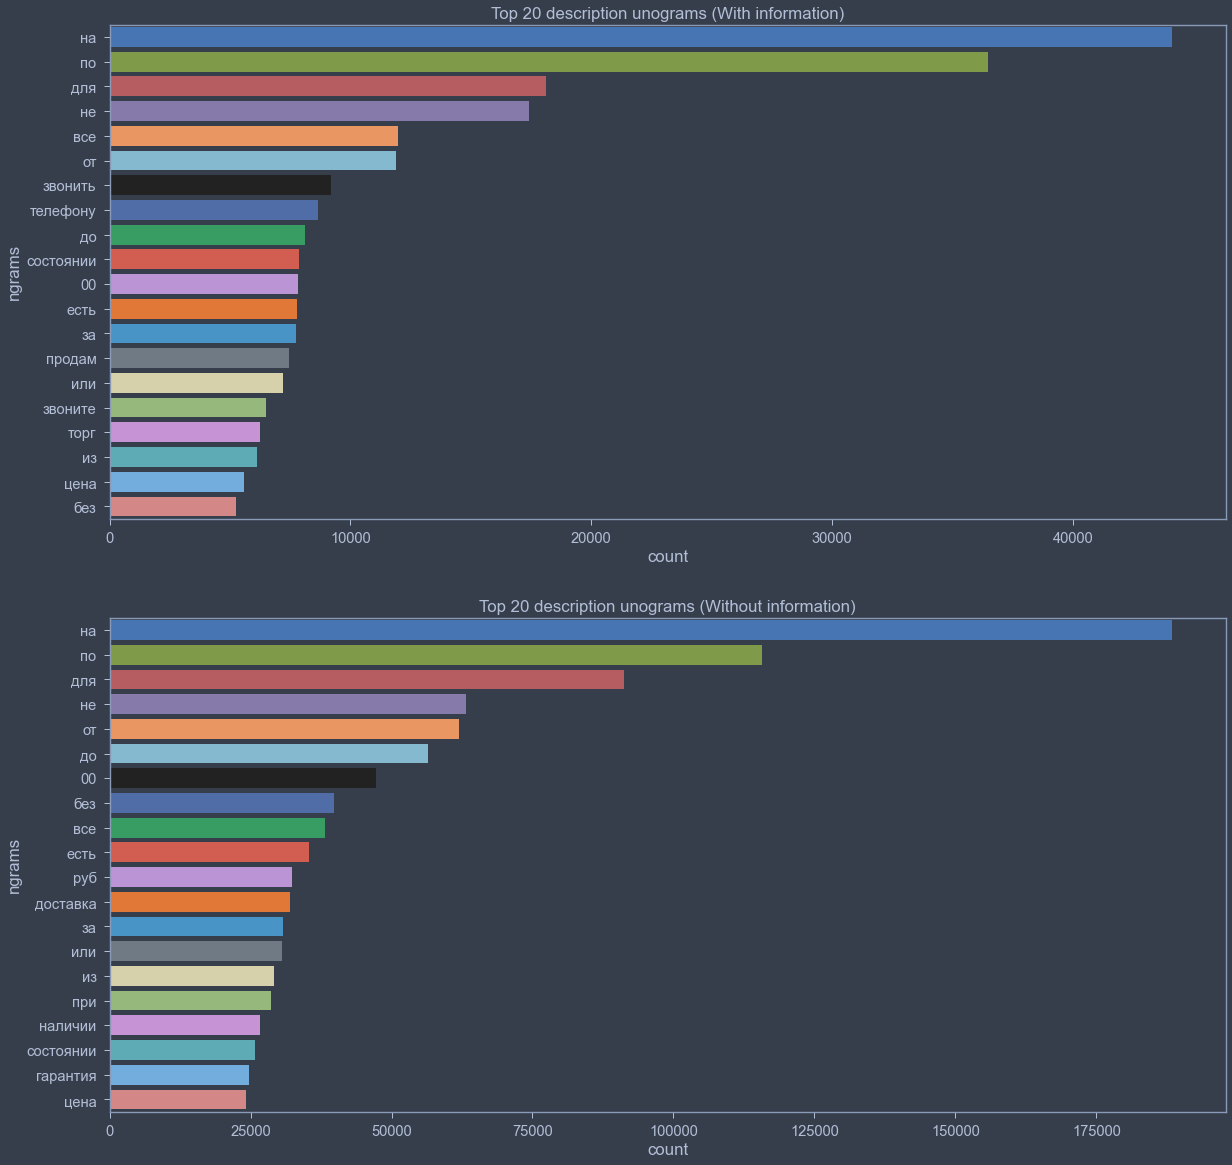

In [20]:
plt.figure(figsize = (20, 20))

plt.subplot(2, 1, 1)
sns.barplot(x = unograms_1['count'], y = unograms_1['ngrams'])
plt.title('Top 20 description unograms (With information)')

plt.subplot(2, 1, 2)
sns.barplot(x = unograms_0['count'], y = unograms_0['ngrams'])
plt.title('Top 20 description unograms (Without information)')

plt.show()

В объявлениях с контактной информацией чаще встречаются биграммы и триграммы, указывающие на возможный способ связи

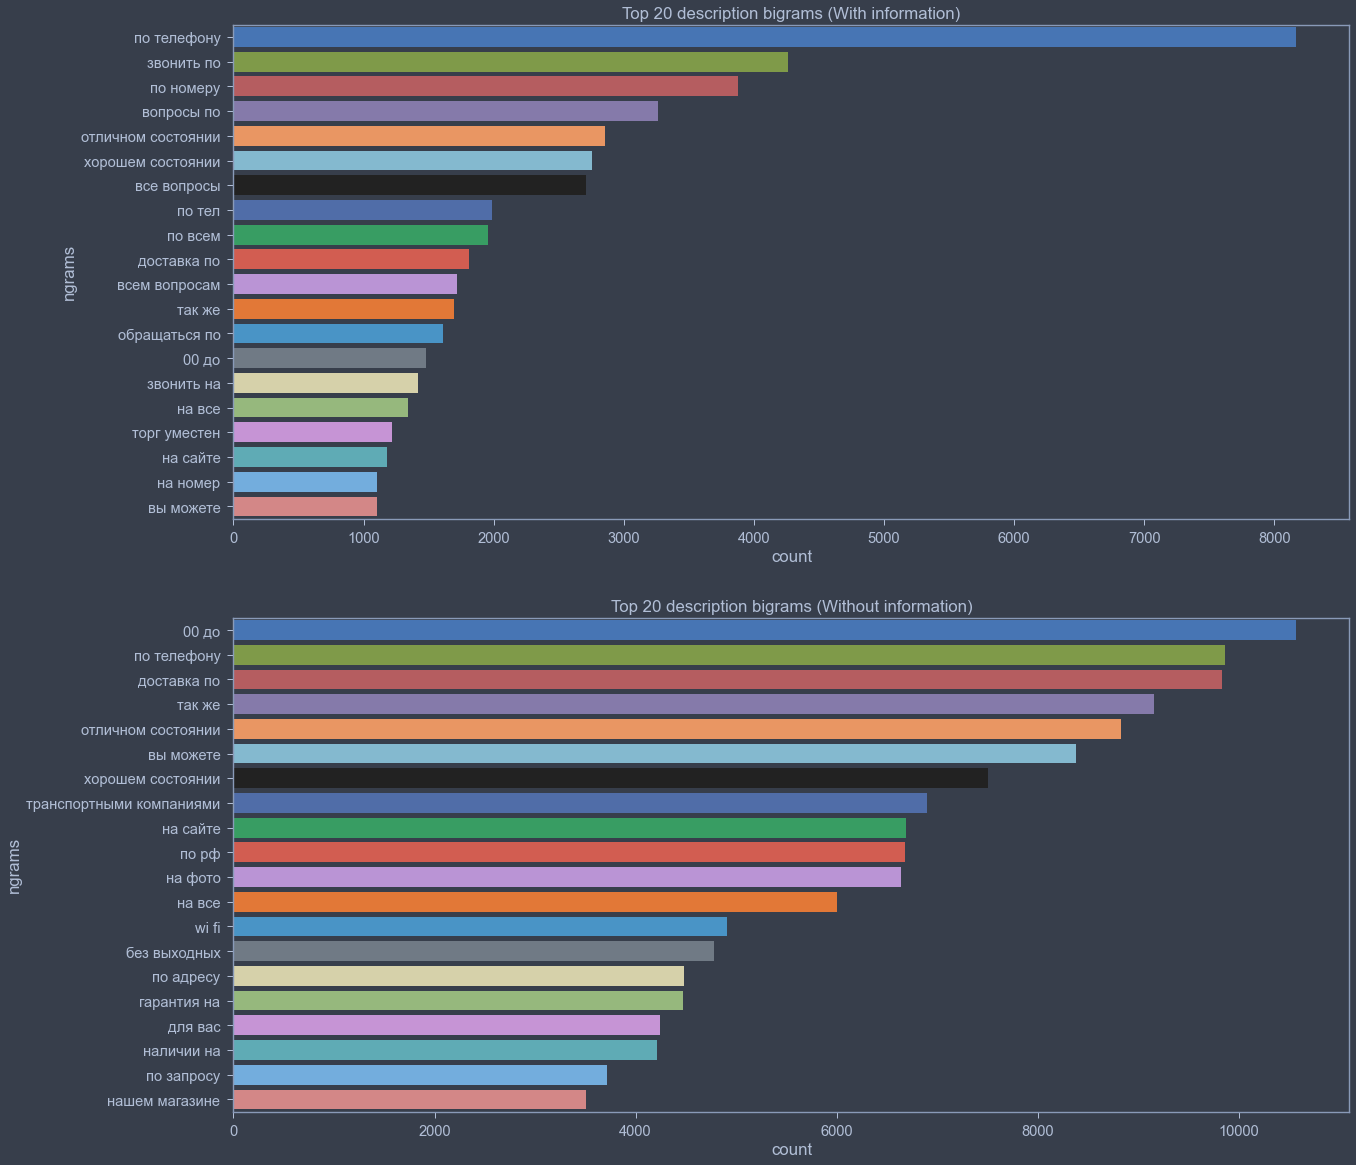

In [21]:
plt.figure(figsize = (20, 20))

plt.subplot(2, 1, 1)
sns.barplot(x = bigrams_1['count'], y = bigrams_1['ngrams'])
plt.title('Top 20 description bigrams (With information)')

plt.subplot(2, 1, 2)
sns.barplot(x = bigrams_0['count'], y = bigrams_0['ngrams'])
plt.title('Top 20 description bigrams (Without information)')

plt.show()

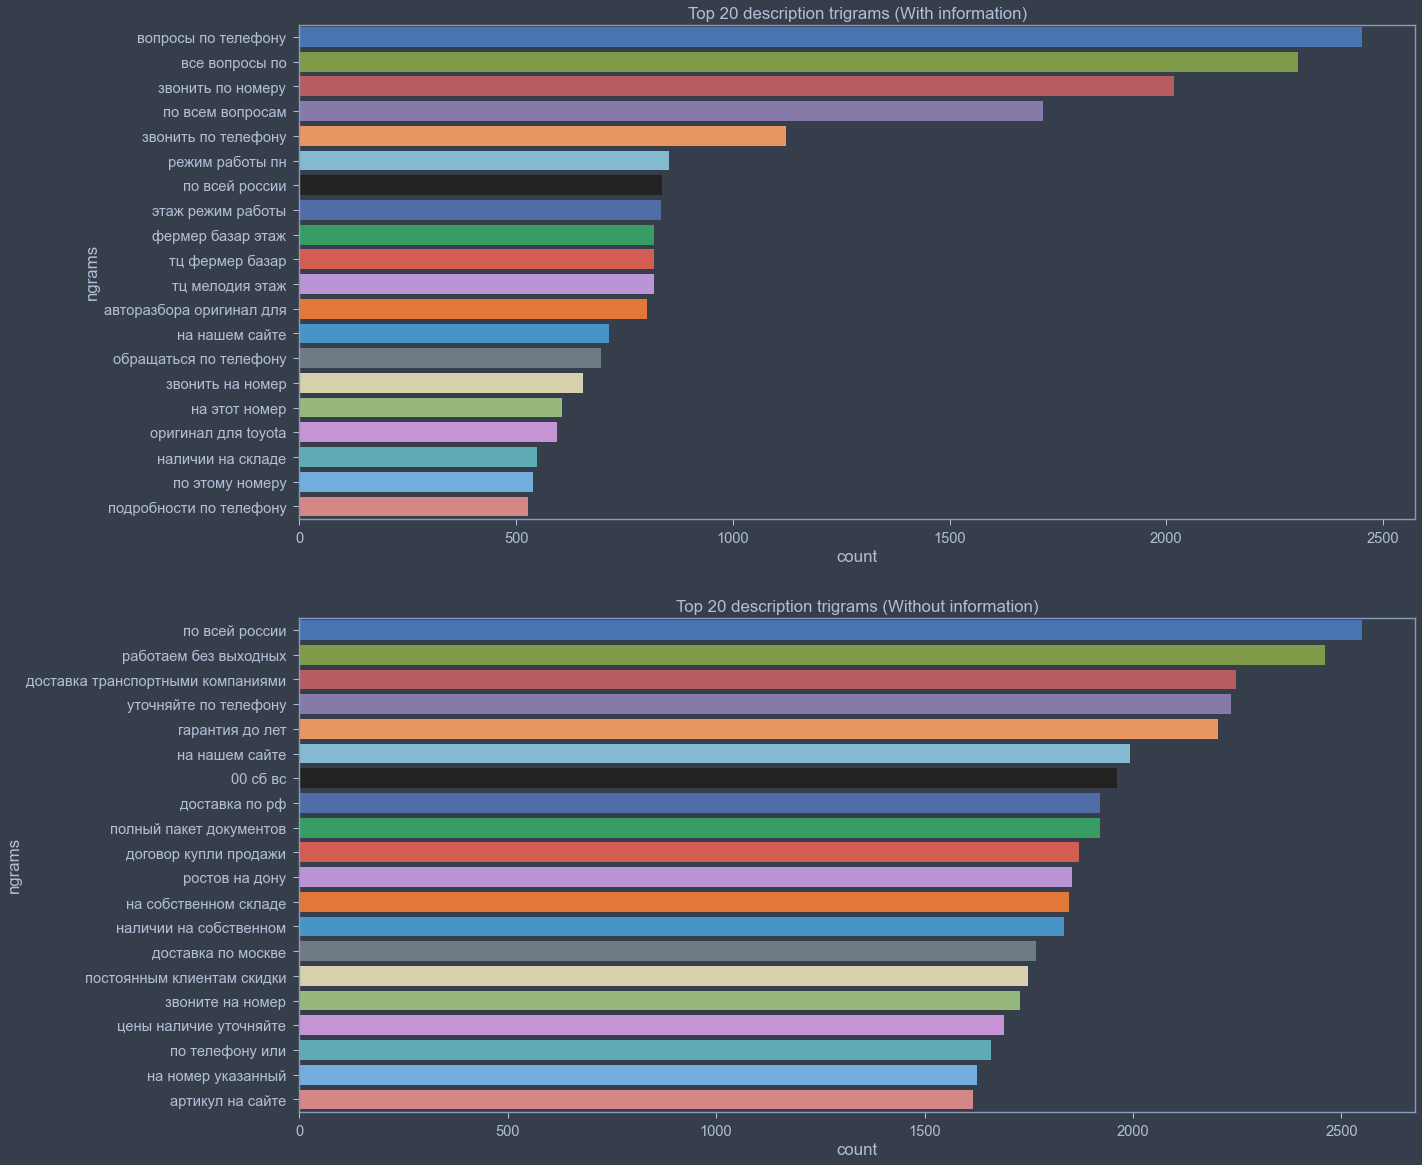

In [22]:
plt.figure(figsize = (20, 20))

plt.subplot(2, 1, 1)
sns.barplot(x = trigrams_1['count'], y = trigrams_1['ngrams'])
plt.title('Top 20 description trigrams (With information)')

plt.subplot(2, 1, 2)
sns.barplot(x = trigrams_0['count'], y = trigrams_0['ngrams'])
plt.title('Top 20 description trigrams (Without information)')

plt.show()

$ N-grams $ $ for $ $ title $

In [23]:
#Text lower
data['title'] = data['title'].apply(lambda x: x.lower())
data_1['title'] = data_1['title'].apply(lambda x: x.lower())
data_0['title'] = data_0['title'].apply(lambda x: x.lower())

#n-grams
unograms = count_grams(data['title'], 1, 1)
bigrams = count_grams(data['title'], 2, 2)
trigrams = count_grams(data['title'], 3, 3)

<ipython-input-23-2c42dbb0ff57>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['title'] = data_1['title'].apply(lambda x: x.lower())
<ipython-input-23-2c42dbb0ff57>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_0['title'] = data_0['title'].apply(lambda x: x.lower())


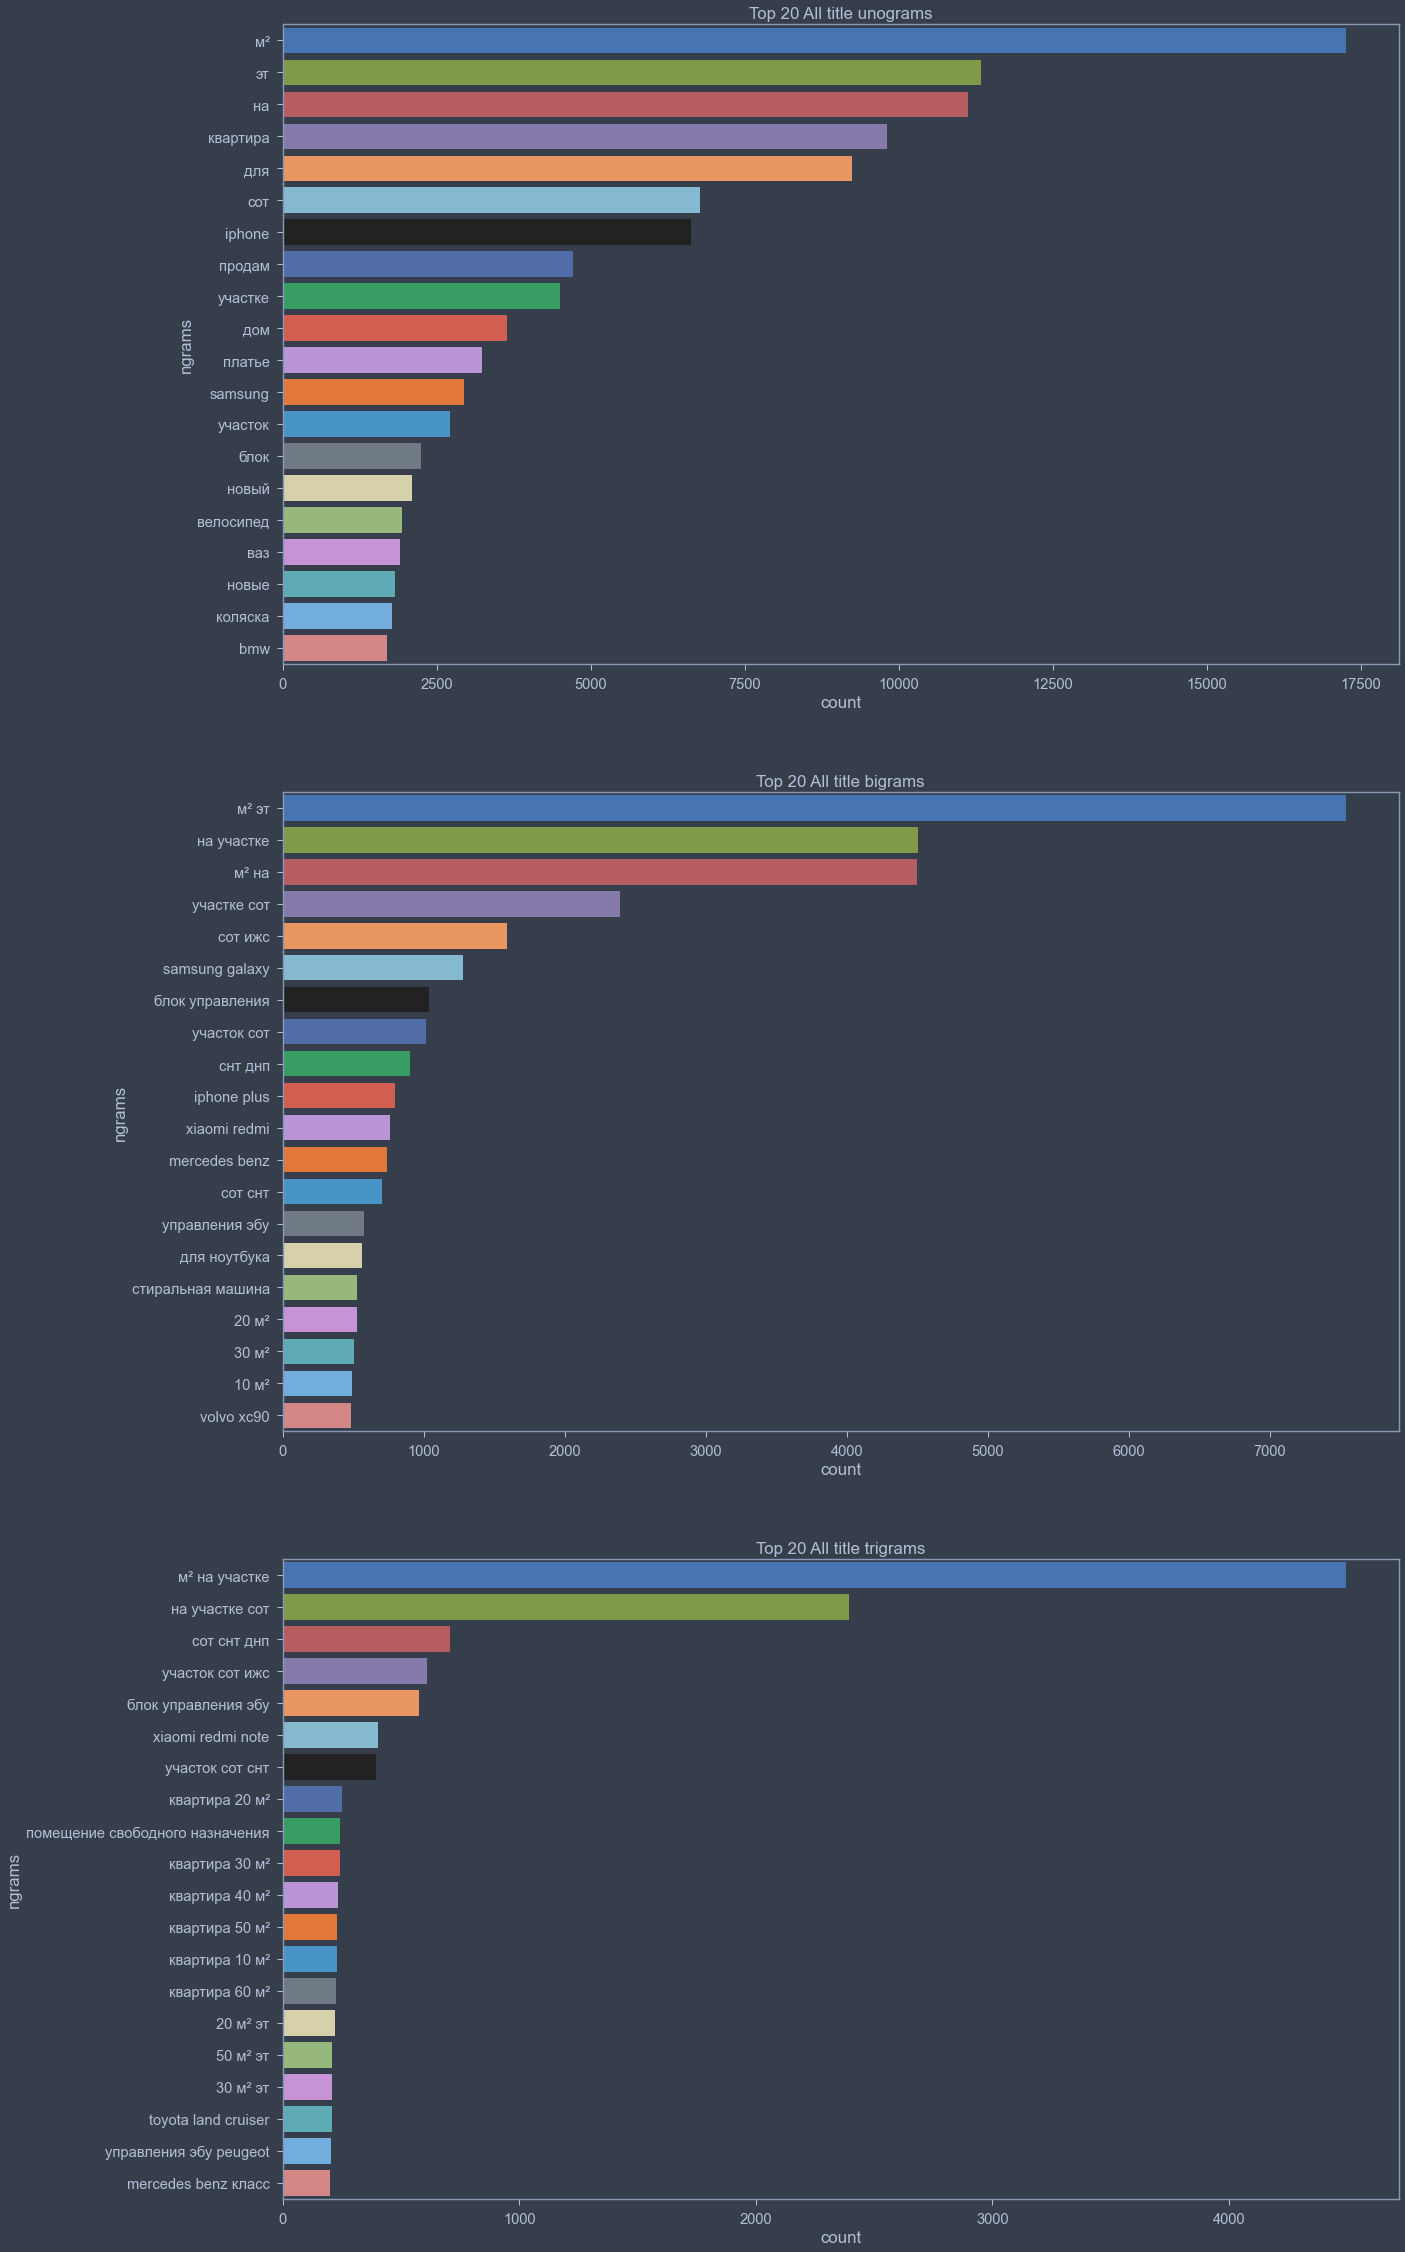

In [24]:
plt.figure(figsize = (20, 40))

plt.subplot(3, 1, 1)
sns.barplot(x = unograms['count'], y = unograms['ngrams'])
plt.title('Top 20 All title unograms')

plt.subplot(3, 1, 2)
sns.barplot(x = bigrams['count'], y = bigrams['ngrams'])
plt.title('Top 20 All title bigrams')

plt.subplot(3, 1, 3)
sns.barplot(x = trigrams['count'], y = trigrams['ngrams'])
plt.title('Top 20 All title trigrams')

plt.show()

In [25]:
#n-grams (without info)
unograms_0 = count_grams(data_0['title'], 1, 1)
bigrams_0 = count_grams(data_0['title'], 2, 2)
trigrams_0 = count_grams(data_0['title'], 3, 3)

#n-grams (with info)
unograms_1 = count_grams(data_1['title'], 1, 1)
bigrams_1 = count_grams(data_1['title'], 2, 2)
trigrams_1 = count_grams(data_1['title'], 3, 3)

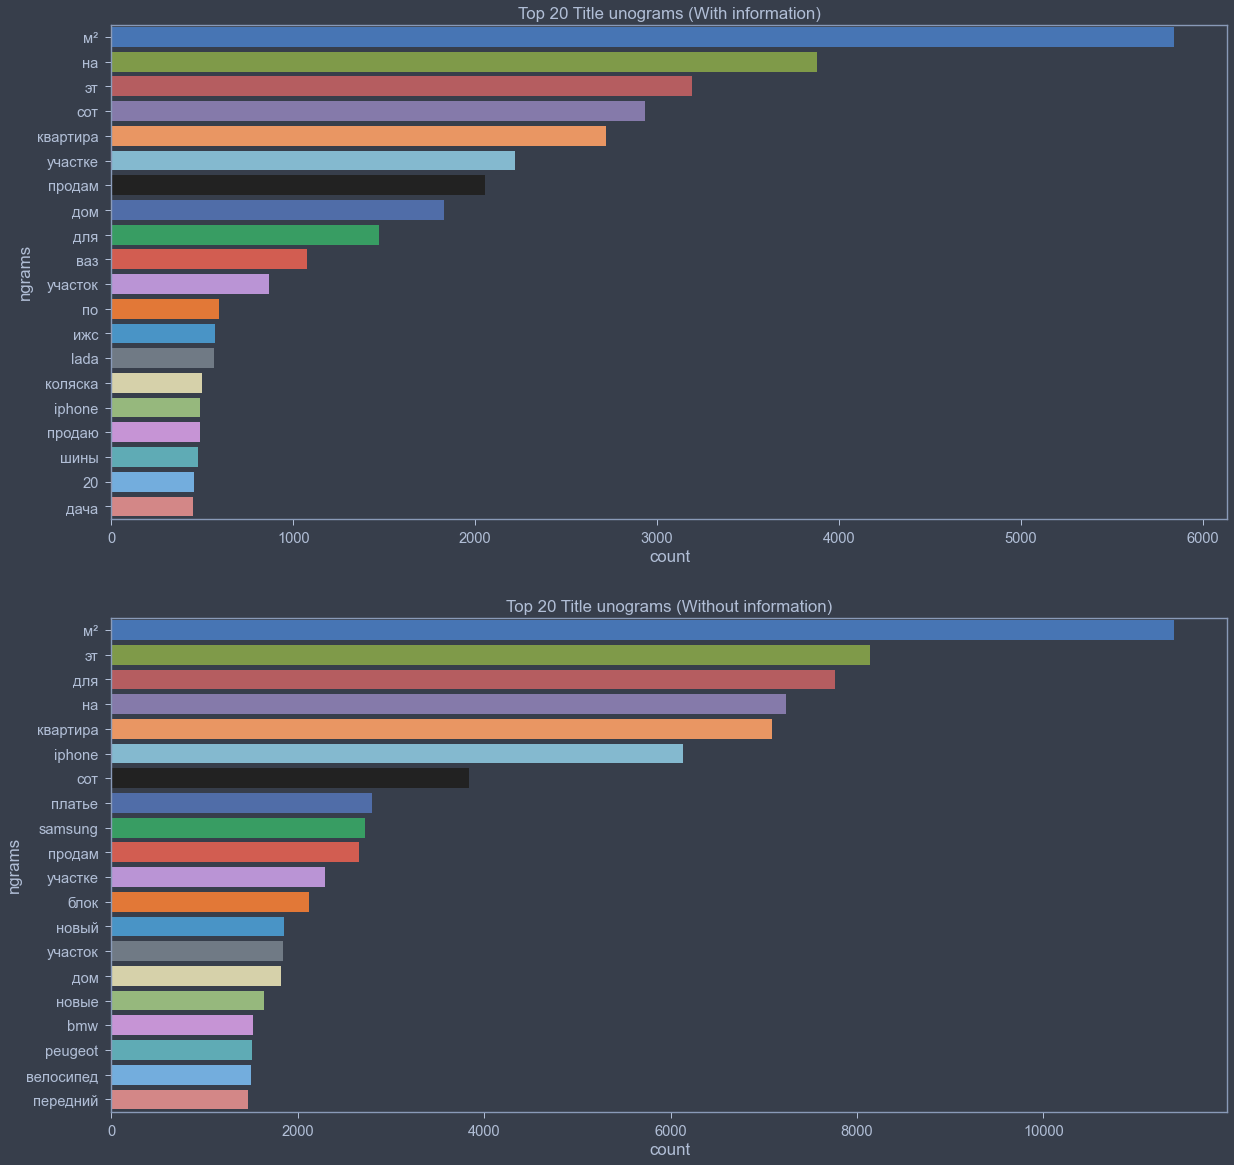

In [26]:
plt.figure(figsize = (20, 20))

plt.subplot(2, 1, 1)
sns.barplot(x = unograms_1['count'], y = unograms_1['ngrams'])
plt.title('Top 20 Title unograms (With information)')

plt.subplot(2, 1, 2)
sns.barplot(x = unograms_0['count'], y = unograms_0['ngrams'])
plt.title('Top 20 Title unograms (Without information)')

plt.show()

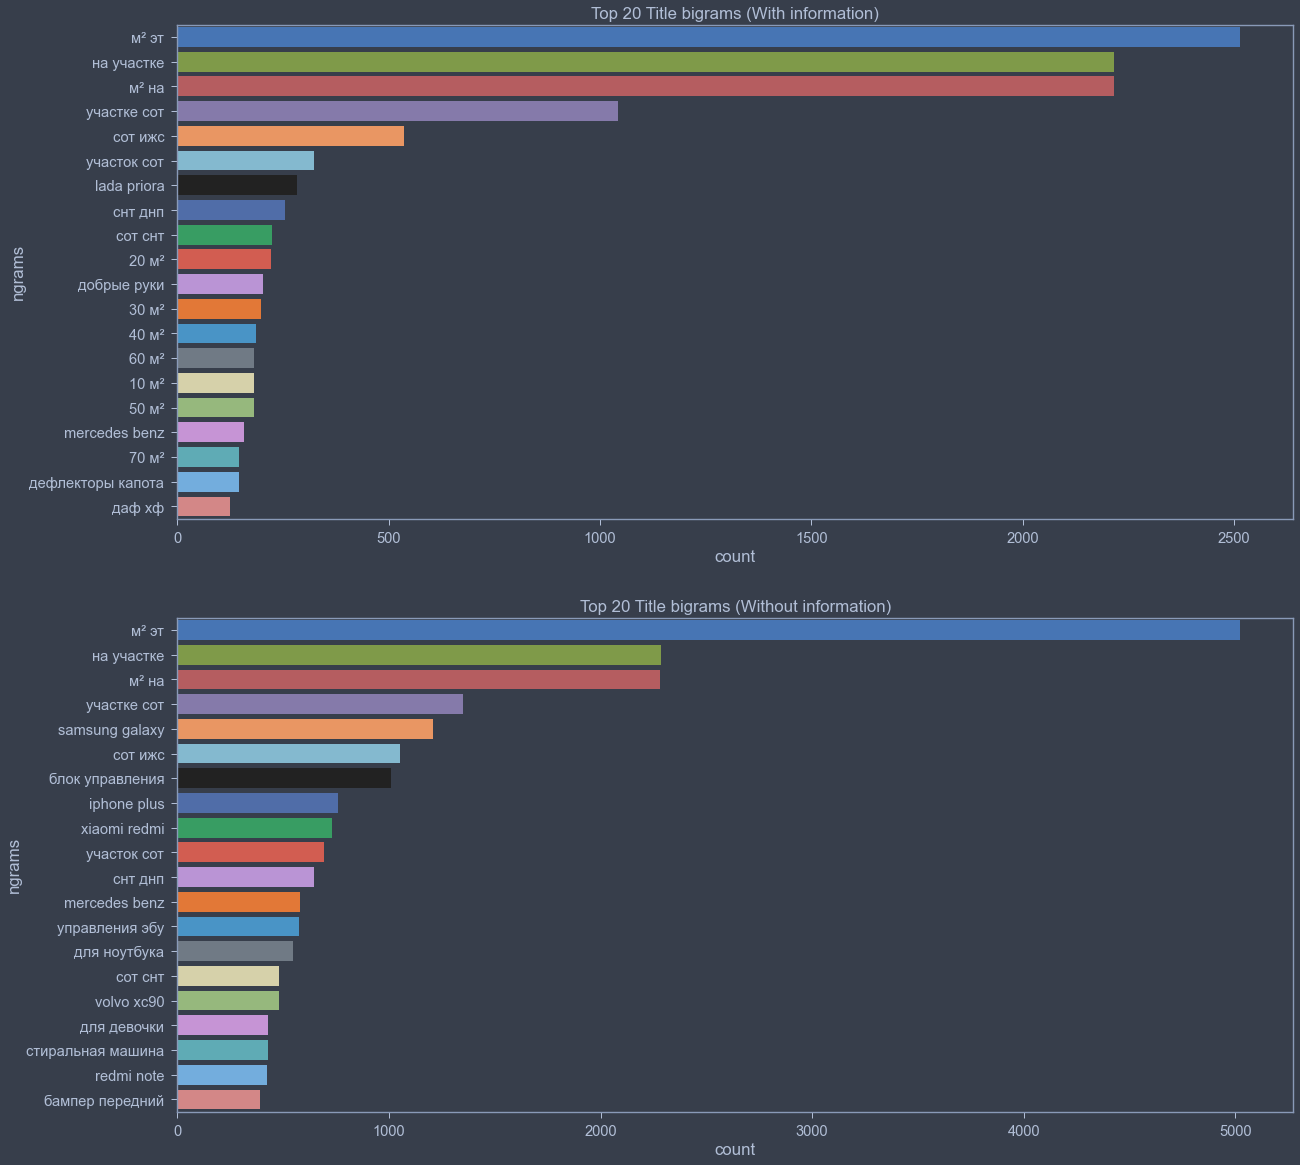

In [27]:
plt.figure(figsize = (20, 20))

plt.subplot(2, 1, 1)
sns.barplot(x = bigrams_1['count'], y = bigrams_1['ngrams'])
plt.title('Top 20 Title bigrams (With information)')

plt.subplot(2, 1, 2)
sns.barplot(x = bigrams_0['count'], y = bigrams_0['ngrams'])
plt.title('Top 20 Title bigrams (Without information)')

plt.show()

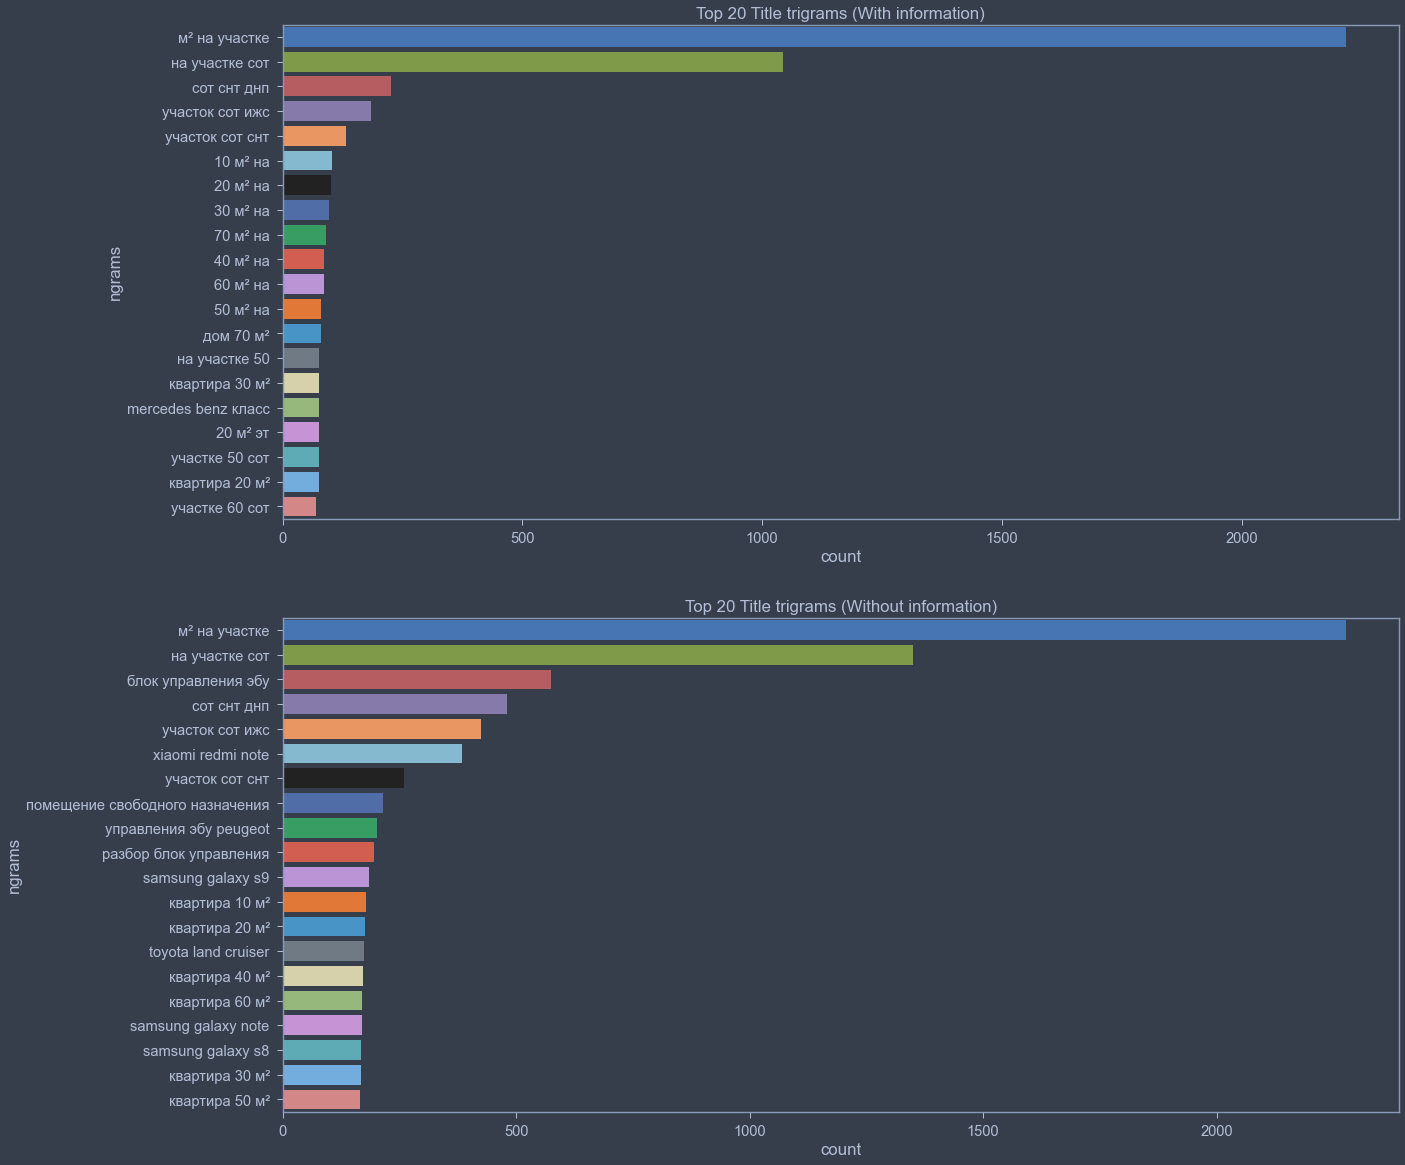

In [28]:
plt.figure(figsize = (20, 20))

plt.subplot(2, 1, 1)
sns.barplot(x = trigrams_1['count'], y = trigrams_1['ngrams'])
plt.title('Top 20 Title trigrams (With information)')

plt.subplot(2, 1, 2)
sns.barplot(x = trigrams_0['count'], y = trigrams_0['ngrams'])
plt.title('Top 20 Title trigrams (Without information)')

plt.show()

# Text preprocessing

In [29]:
#Concat all text
data['all_text'] = data['title'] + ' ' + data['description'] + \
                       ' ' + data['region'] + ' ' + data['city']

In [30]:
#Preprocess function
def text_preprocess(text):
    text = text.lower()
    text = re.sub('\n', ' ', text)
    text = re.sub('\t', ' ', text)
    text = re.sub('х\d', ' ', text)
    text = re.sub('×', ' ', text)
    text = re.sub('б/у', ' бывший употребление ', text)
    text = re.sub('пн-пт', ' будни ', text)
    text = re.sub('сб-вс', ' выходные ', text)
    text = re.sub('\sм.кв.\s', ' метр квадратный ', text)
    text = re.sub('\d+:\d+ до \d+:\d+', ' время работы ', text)
    text = re.sub("[!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+", ' ', text)
    text = re.sub('\sэт\s', ' этаж ', text)
    text = re.sub('\sрф\s', ' россия ', text)
    text = re.sub('\sтел\s', ' телефон ', text)
    text = re.sub('\sсм\s', ' сантиметр ', text)
    text = re.sub('\sга\s', ' гектар ', text)
    text = re.sub('\sкв\s', ' квадратный ', text)
    text = re.sub('\sм\s', ' метр ', text)
    text = re.sub('\sкм\s', ' километр ', text)
    text = re.sub('\sга\s', ' гектар ', text)
    text = re.sub('\sул\s', ' улица ', text)
    text = re.sub('\sруб\s', ' рубль ', text)
    text = re.sub('\sтц\s', ' торговый центр ', text)
    text = re.sub('\sтк\s', ' торговый комплекс ', text)
    text = re.sub('₽', ' рубль ', text)
    text = re.sub('\sшт\s', ' штука ', text)
    text = re.sub('\sбу\s', ' бывший употребление ', text)
    text = re.sub('\sпн\s', ' понедельник ', text)
    text = re.sub('\sвт\s', ' вторник ', text)
    text = re.sub('\sср\s', ' среда ', text)
    text = re.sub('\sчт\s', ' четверг ', text)
    text = re.sub('\sпт\s', ' пятница ', text)
    text = re.sub('\sсб\s', ' суббота ', text)
    text = re.sub('\sвскр\s', ' воскресенье ', text)
    text = re.sub('\sвс\s', ' воскресенье ', text)
    text = re.sub('\sчел\s', ' человек ', text)
    text = re.sub('\sм2\s', ' метр квадратный ', text)
    text = re.sub('\sм3\s', ' метр кубический ', text)
    text = re.sub('\sмм\s', ' миллиметр ', text)
    text = re.sub('\sд\s', ' дом ', text)
    text = re.sub('\sстр\s', ' строение ', text)
    text = re.sub('\sсот\s+8', ' телефон восемь', text)
    text = re.sub('\w²', ' квадратный ', text)
    text = re.sub('\w³', ' кубический ', text)
    text = re.sub('\wˉ¹', ' ', text)
    text = re.sub('[⁰❶❷❸❹❺❻❼❽❾❿]', ' ', text)
    text = re.sub('[①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮⑯⑰⑱⑲⑳]', ' ', text)
    text = re.sub('[➊➋➌➍➎➏➐➑➒]', ' ', text)
    text = re.sub('[ˉ⁴ˉ³ˉ²ˉ¹⁰¹²³⁴⁵⁶⁷⁸⁹]', ' ', text)
    return text

#Text_preprocess
data['all_text'] = data['all_text'].apply(lambda x: text_preprocess(x))

#del symbols
def del_sybmols(text):
    text = ''.join([' ' if not i.isalnum() else i for i in text])
    return text

#del symbols function
data['all_text'] = data['all_text'].apply(lambda x: del_sybmols(x))

In [31]:
#Lemmatizer
morph = MorphAnalyzer()
  
#Stop words
stop_words = stopwords.words('russian')
more_stop_words = ['которых', 'которые', 'твой', 'которой', 'которого', 'сих', 'ком', 'свой', 'твоя',
                   'этими', 'слишком', 'нами', 'всему', 'будь', 'саму', 'чаще', 'ваше', 'сами', 'наш',
                   'затем', 'еще', 'самих', 'наши', 'ту', 'каждое', 'мочь', 'весь', 'этим', 'наша',
                   'своих', 'оба', 'который', 'зато', 'те', 'этих', 'вся', 'ваш', 'такая', 'теми',
                   'ею', 'которая', 'нередко', 'каждая', 'также', 'чему', 'собой', 'самими', 'нем',
                   'вами', 'ими', 'откуда', 'такие', 'тому', 'та', 'очень', 'сама', 'нему', 'алло',
                   'оно', 'этому', 'кому', 'тобой', 'таки', 'твоё', 'каждые', 'твои', 'мой', 'нею',
                   'самим', 'ваши', 'ваша', 'кем', 'мои', 'однако', 'сразу', 'свое', 'ними', 'всё',
                   'неё', 'тех', 'хотя', 'всем', 'тобою', 'тебе', 'одной', 'другие', 'эта', 'само',
                   'эта', 'буду', 'самой', 'моё', 'своей', 'такое', 'всею', 'будут', 'своего', 'кого',
                   'свои', 'мог', 'нам', 'особенно', 'её', 'самому', 'наше', 'кроме', 'вообще', 'вон',
                   'мною', 'никто', 'это']
for i in more_stop_words:
    stop_words.append(i)

In [32]:
#Lemmatize function
def lemmatize(token_sentence): 
    tokens = []
    for token in token_sentence:
            if token not in stop_words \
            and token != ' ' \
            and token.strip() not in punctuation \
            and len(token) > 1:
                token = token.strip()
                token = morph.normal_forms(token)[0]
                tokens.append(token)
    if len(tokens) > 1:
        return ' '.join(tokens)
    return None

#Tokens
data['all_tokens'] = data['all_text'].apply(nltk.word_tokenize)

#Lemmatize
data['clear_text'] = data['all_tokens'].apply(lambda x: lemmatize(x))

#num to word
def NumToWord(text):
    text = ''.join([' ' + num2words(i, lang = 'ru') + ' ' if i.isdigit() else i for i in text])
    return text

#text with num2word
data['clear_text'] = data['clear_text'].apply(lambda x: NumToWord(x))

#save data
data.to_csv('clear_data.csv', columns = ['clear_text', 'is_bad'], index = False)

# EDA (Clear text)

In [33]:
#n-grams (without info)
unograms_0 = count_grams(data['clear_text'][data['is_bad'] == 0], 1, 1)
bigrams_0 = count_grams(data['clear_text'][data['is_bad'] == 0], 2, 2)
trigrams_0 = count_grams(data['clear_text'][data['is_bad'] == 0], 3, 3)

#n-grams (with info)
unograms_1 = count_grams(data['clear_text'][data['is_bad'] == 1], 1, 1)
bigrams_1 = count_grams(data['clear_text'][data['is_bad'] == 1], 2, 2)
trigrams_1 = count_grams(data['clear_text'][data['is_bad'] == 1], 3, 3)

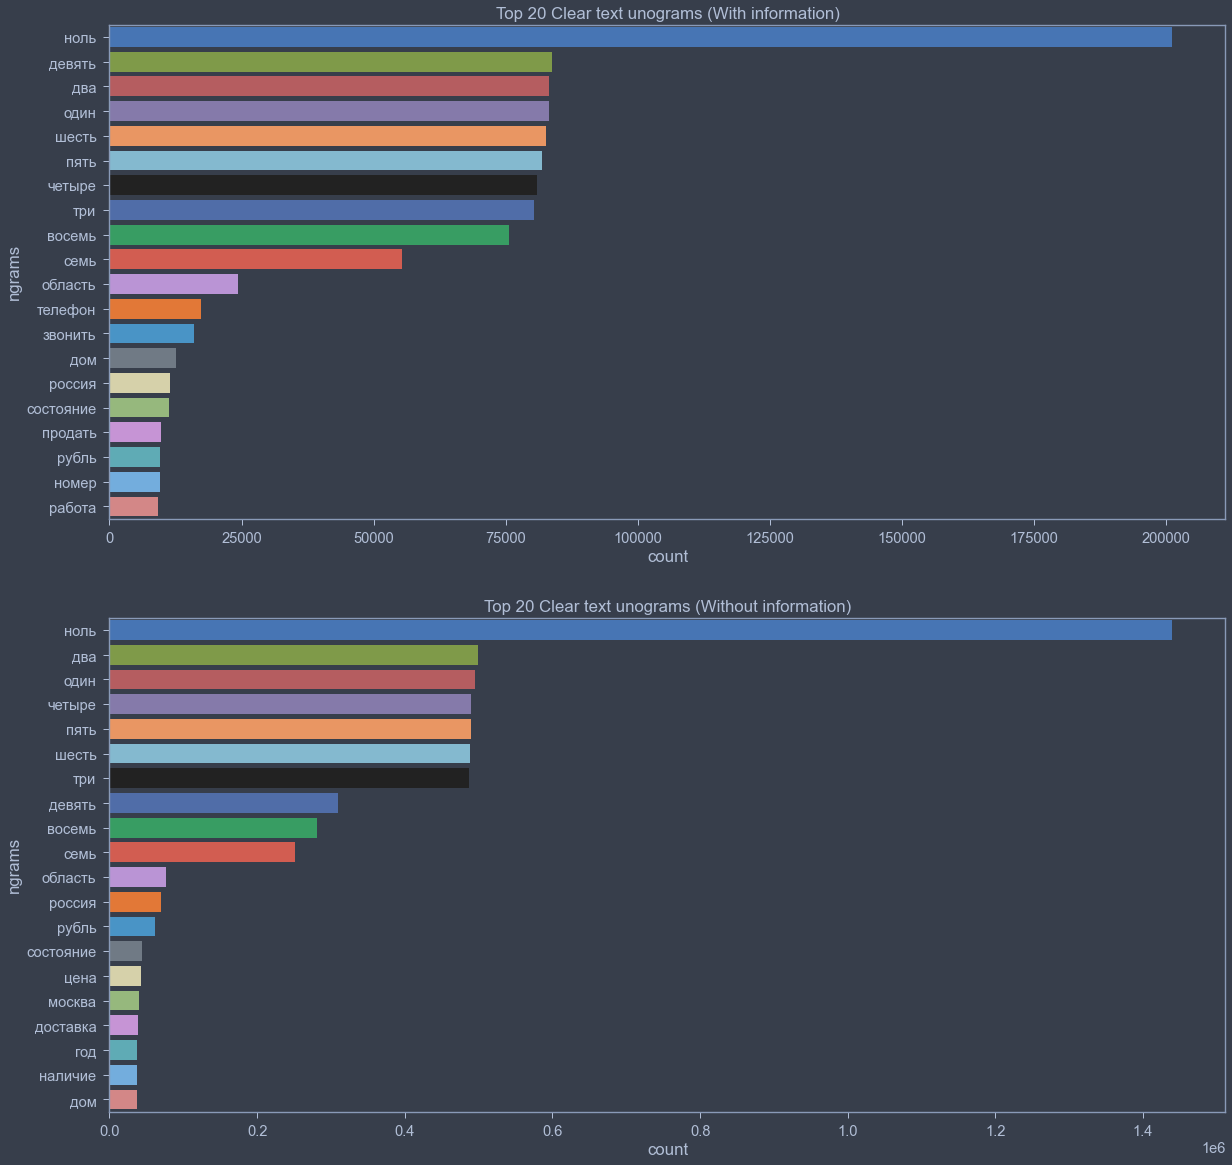

In [34]:
plt.figure(figsize = (20, 20))

plt.subplot(2, 1, 1)
sns.barplot(x = unograms_1['count'], y = unograms_1['ngrams'])
plt.title('Top 20 Clear text unograms (With information)')

plt.subplot(2, 1, 2)
sns.barplot(x = unograms_0['count'], y = unograms_0['ngrams'])
plt.title('Top 20 Clear text unograms (Without information)')

plt.show()

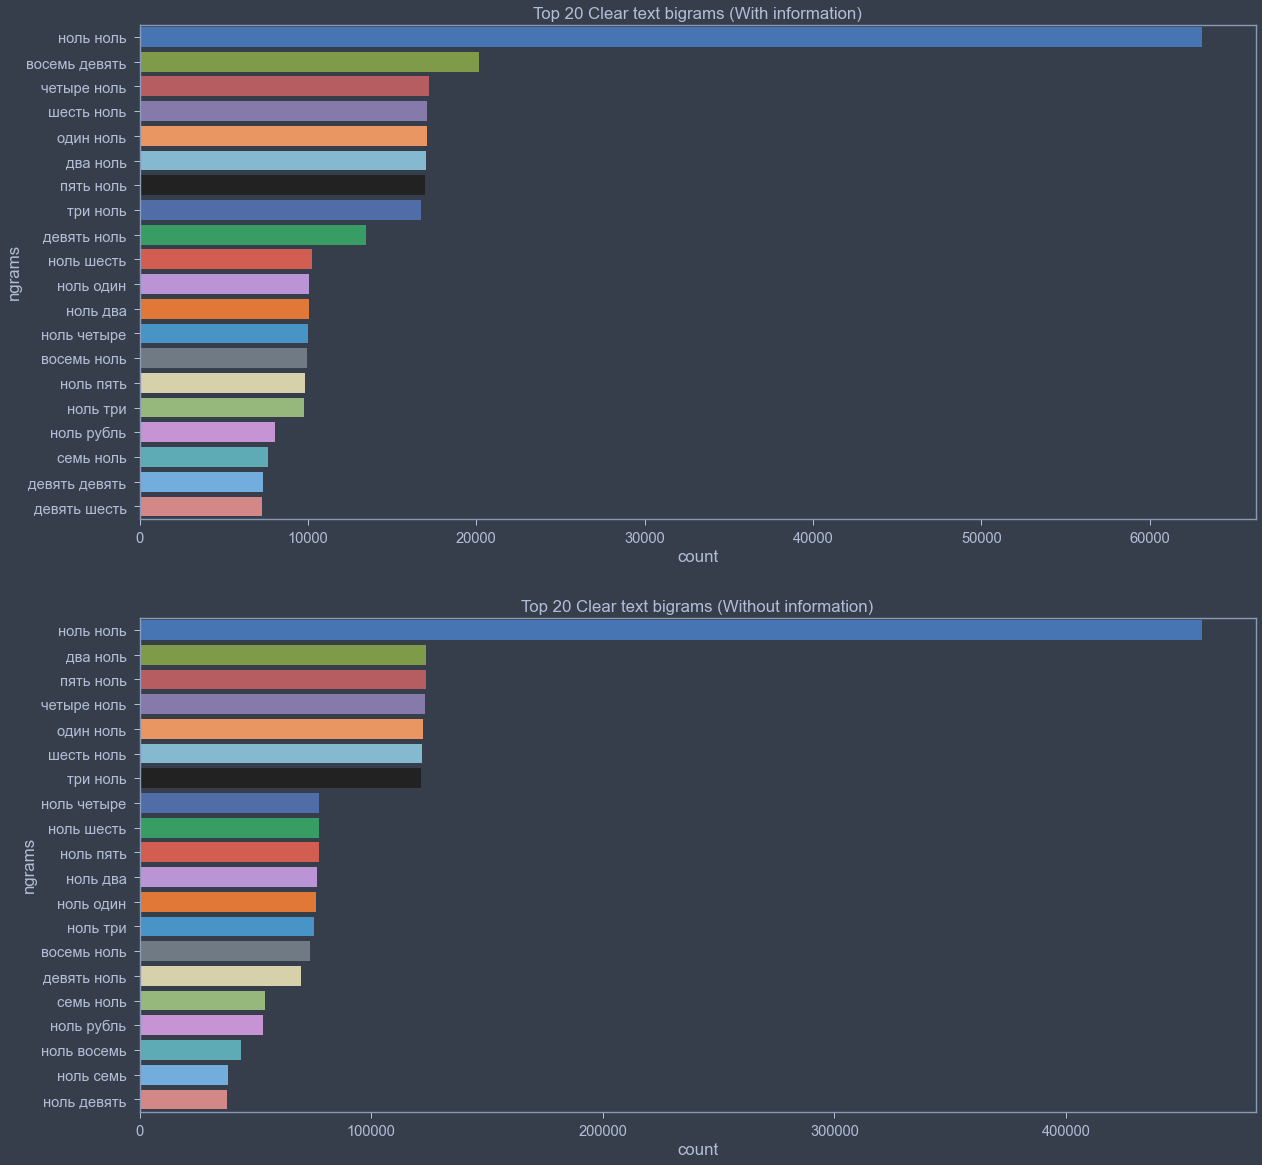

In [35]:
plt.figure(figsize = (20, 20))

plt.subplot(2, 1, 1)
sns.barplot(x = bigrams_1['count'], y = bigrams_1['ngrams'])
plt.title('Top 20 Clear text bigrams (With information)')

plt.subplot(2, 1, 2)
sns.barplot(x = bigrams_0['count'], y = bigrams_0['ngrams'])
plt.title('Top 20 Clear text bigrams (Without information)')

plt.show()

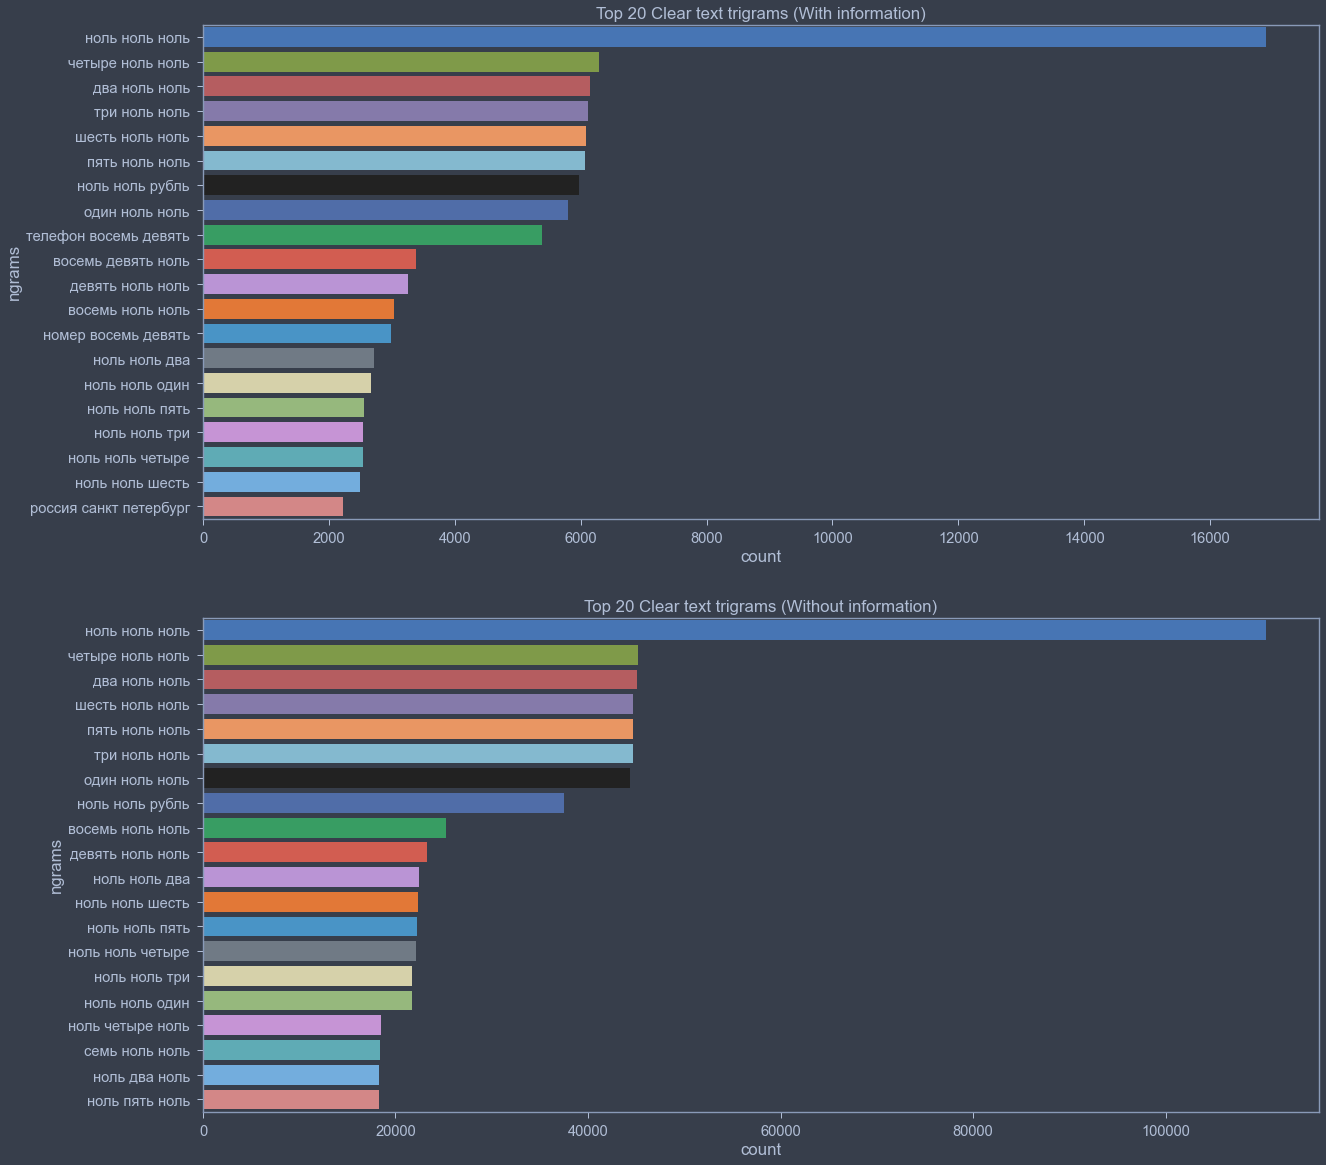

In [36]:
plt.figure(figsize = (20, 20))

plt.subplot(2, 1, 1)
sns.barplot(x = trigrams_1['count'], y = trigrams_1['ngrams'])
plt.title('Top 20 Clear text trigrams (With information)')

plt.subplot(2, 1, 2)
sns.barplot(x = trigrams_0['count'], y = trigrams_0['ngrams'])
plt.title('Top 20 Clear text trigrams (Without information)')

plt.show()